# Data Exploration Notebook
This is a notebook that serves as a jumping off point for how to explore GOES data and IBtracks data - mostly via xarray (and by extension netCDF).

First lets start by loading some data:

In [1]:
# first, imports
import xarray as xr
import metpy
import numpy as np
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from metpy.plots.ctables import registry
import os
from datetime import timedelta
from tqdm import tqdm

In [2]:
# next, start with loading storm data
# stormfp = os.getcwd()+"/data/all_storm_data.nc"  # all storm data since 1800s
%matplotlib inline
stormfp = os.getcwd()+"/data/IBTrACS.since1980.v04r00.nc"  # all storm data since 1980 (much smaller dataset)
stormdata = xr.open_dataset(stormfp)
stormdata

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4484)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

# NetCDF file exploration
Now that we've opened some data and done some visualization of the water vapor data, lets dive into the storm data:

In [3]:
# we can access the netCDF object by the following. Lets look at the attributes of the loaded file:
stormdata

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4484)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/147)
    numobs            (storm) float32 41.0 13.0 79.0 9.0 ... 41.0 9.0 93.0 31.0
    sid               (storm) |S13 b'1980001S13173' ... b'2021111S10049'
    season            (storm) float32 1.98e+03 1.98e+03 ... 2.021e+03 2.021e+03
    number            (storm) int16 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [4]:
# from the above, we see that there are 3 dimensions: date_time, quadrant, and storm. Lets look at a recent storm (larger storm coord)
# this indexing comes from the xarray documentation (stormdata is a dataSET not a dataARRAY): http://xarray.pydata.org/en/stable/user-guide/indexing.html#dataset-indexing
storm = stormdata.isel(storm=[4483])

# we can also load storm attributes like name, lat, long
time = storm.time.values[0,1]
name = storm.name.values
lat_list = storm.lat.values[0, :] # 2d, slice into a vector
lon_list = storm.lon.values[0, :]
print(name)
print(time)
print(lat_list[0:10],"...")
print(lon_list[0:10],"...")

[b'JOBO']
2021-04-21T03:00:00.000039936
[-10.        -9.827602  -9.7       -9.654928  -9.7       -9.819987
 -10.       -10.252432 -10.4      -10.2376  ] ...
[48.8      48.47491  48.2      48.       47.800003 47.522503 47.2
 46.8727   46.5      46.034687] ...


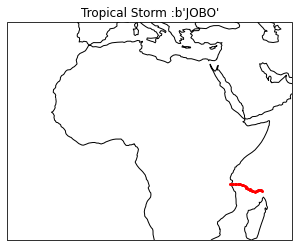

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
plt.title("Tropical Storm :{}".format(name[0]))
ax.set_extent([-31.582165456058775, 58.34038648061951, -25.5009017568916962, 43.055208930895745], ccrs.PlateCarree())
for x,y in zip(lat_list, lon_list):
    plt.plot(y,x, markersize=2, marker='o', color='red')

As you can see in the above map, there appears to be a tropical storm named Jobo north of Madagascar on April, 4, 2021. A quick google search shows that this indeed did occur in the location on the date described by the IBTrACS data

(https://www.accuweather.com/en/hurricane/indian/jobo-2021)

# Water Vapor Data
Now that we've explored some tropical storm data, lets look at water vapor in the atmosphere

In [6]:
# next, load in GOES-15 WV data
wvfp = "/Users/rmcmahon/dev/cyclone_classifier/data/dorian.nc"
wv = xr.open_dataset(wvfp)
wv_timestamp = np.datetime64(wv.date_created)
print(wv_timestamp)
wv

2019-09-02T00:10:00.500


<ipython-input-6-ba4aa54b0f6c>:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  wv_timestamp = np.datetime64(wv.date_created)


<xarray.Dataset>
Dimensions:                                           (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1518 ... ...
  * x                                                 (x) float32 -0.1518 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int32 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/33)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    esun                                              float32 ...
    kappa0                                            float32 ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2019-09-02T00:00:19.2Z
    time_coverage_end:         2019-09-02T00:09:50.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    n/a
    id:                        07dc66e0-b49b-4f9b-8fb4-434b3676f8f1

In [7]:
# find associated storm data
# We can do this by trying to match time periods to our water vapor data
def match_storm(stormdata, wv_timestamp):
    for stormid in tqdm(stormdata.storm[3500:]):
        storm = stormdata.isel(storm=[stormid])
        time_deltas = [abs(wv_timestamp-time_i) for time_i in storm.time.values[0,:]]
        time_comp = [tdel_i < np.timedelta64(15,'h') for tdel_i in time_deltas]
        if sum(time_comp) > 0:
            return stormdata.isel(storm=[stormid])
wv_storm = match_storm(stormdata, wv_timestamp)
wv_storm

 79%|███████▉  | 779/984 [00:15<00:04, 51.05it/s]


<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 1)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/147)
    numobs            (storm) float32 133.0
    sid               (storm) |S13 b'2019236N10314'
    season            (storm) float32 2.019e+03
    number            (storm) int16 52
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [8]:
wv_storm.time

<xarray.DataArray 'time' (storm: 1, date_time: 360)>
array([['2019-08-24T06:00:00.000039936', '2019-08-24T09:00:00.000039936',
        '2019-08-24T12:00:00.000039936', ...,                           'NaT',
                                  'NaT',                           'NaT']],
      dtype='datetime64[ns]')
Coordinates:
    time     (storm, date_time) datetime64[ns] 2019-08-24T06:00:00.000039936 ...
    lat      (storm, date_time) float32 10.3 10.34 10.4 10.49 ... nan nan nan
    lon      (storm, date_time) float32 -46.4 -46.94 -47.5 ... nan nan nan
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              time
    standard_name:          time
    description:            Nominally, time steps are 3 hourly, but can be mo...
    Note:                   Variable:time can be missing since the tracks are...
    coverage_content_type:  physicalMeasurement

In [9]:
# display some attributes about storm
time = wv_storm.time.values[0,0:10]
name = wv_storm.name.values
lat_list = wv_storm.lat.values[0, :] # 2d, slice into a vector
lon_list = wv_storm.lon.values[0, :]
print(name)
print(time)
print(lat_list[0:10],"...")
print(lon_list[0:10],"...")

[b'DORIAN']
['2019-08-24T06:00:00.000039936' '2019-08-24T09:00:00.000039936'
 '2019-08-24T12:00:00.000039936' '2019-08-24T15:00:00.000039936'
 '2019-08-24T18:00:00.000039936' '2019-08-24T21:00:00.000039936'
 '2019-08-25T00:00:00.000039936' '2019-08-25T03:00:00.000039936'
 '2019-08-25T06:00:00.000039936' '2019-08-25T09:00:00.000039936']
[10.3      10.340152 10.4      10.492429 10.600001 10.699928 10.800001
 10.899776 11.       11.099999] ...
[-46.4      -46.940014 -47.5      -48.092495 -48.7      -49.30753
 -49.9      -50.442566 -51.       -51.642525] ...


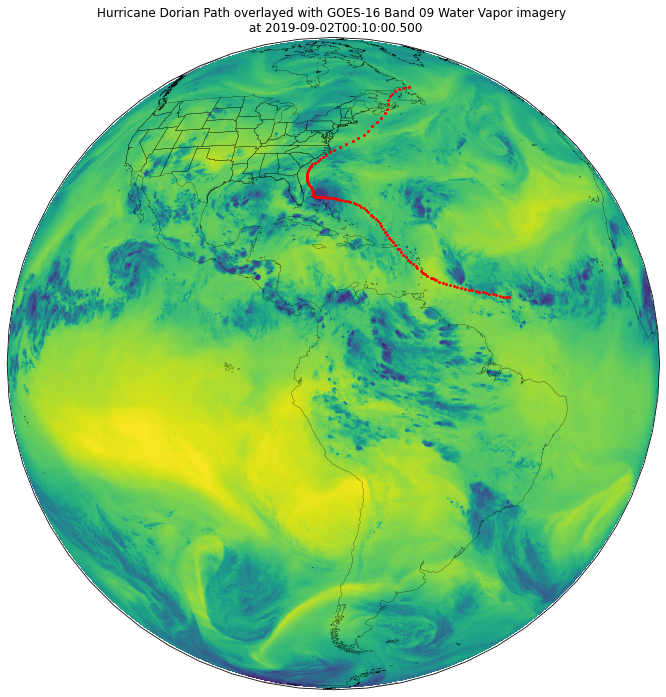

In [28]:
dat = wv.metpy.parse_cf('CMI')
geos = dat.metpy.cartopy_crs
x = dat.x
y = dat.y
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = plt.axes(projection=geos)
plt.title("Hurricane Dorian Path overlayed with GOES-16 Band 09 Water Vapor imagery \n at {}".format(wv_timestamp))
wv_data = wv['CMI'].data
ax.imshow(wv_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)
# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
for x,y in zip(lat_list, lon_list):
    ax.plot(y,x, markersize=2, marker='o', color='red', transform=ccrs.Geodetic())
